<a href="https://colab.research.google.com/github/linhlinhle997/object-detection-techniques/blob/features%2Fod-part1/class_bbox_reg_2obj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Classification (> 2 objects in an image) + Bounding Box Regression

In [ ]:
import kagglehub
import shutil
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib import patches
import xml.etree.ElementTree as ET
from PIL import Image
import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.models.resnet import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Download Dataset

In [ ]:
dataset = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
data_dir = "/content/dog-and-cat-detection"
shutil.move(dataset, data_dir)

100%|██████████| 1.03G/1.03G [00:49<00:00, 22.5MB/s]

Extracting files...


'/content/dog-and-cat-detection'

In [ ]:
!cat /content/dog-and-cat-detection/annotations/Cats_Test736.xml


<annotation>
    <folder>images</folder>
    <filename>Cats_Test736.png</filename>
    <size>
        <width>500</width>
        <height>466</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>cat</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>49</xmin>
            <ymin>125</ymin>
            <xmax>111</xmax>
            <ymax>168</ymax>
        </bndbox>
    </object>
    <object>
        <name>cat</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>397</xmin>
            <ymin>103</ymin>
            <xmax>451</xmax>
            <ymax>132</ymax>
        </bndbox>
    </object>
</annotation>

## Dataset and DataLoader Setup

In [ ]:
def calculate_center(bbox):
    return ((bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2)


class ImageDataset(Dataset):
    def __init__(self, annotation_dir, image_dir, transform=None):
        self.annotation_dir = annotation_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects() # Filter valid images

    def filter_images_with_multiple_objects(self):
        valid_images_files = []
        for image_name in os.listdir(self.image_dir):
            # Check if it's a file and get the corresponding annotation file
            if os.path.isfile(os.path.join(self.image_dir, image_name)):
                annotation_name = os.path.splitext(image_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotation_dir, annotation_name)

            # Add image if it has <=1 object
            if self.count_objects_in_annotation(annotation_path) == 1:
                valid_images_files.append(image_name)
        return valid_images_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            # Parse XML and count objects
            tree = ET.parse(annotation_path)
            return len(tree.getroot().findall("object")) # Count objects
        except FileNotFoundError:
            return 0

    def parse_annotation(self, annotation_path):
        # Parse XML to extract object label
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get image size for normalization
        image_width = int(root.find("size/width").text)
        image_height = int(root.find("size/height").text)

        label, bbox = None, None
        for obj in root.findall("object"):
            name = obj.find("name").text
            # If label is not set, take the first label (as the dataset has only one object)
            if label is None:
                label = name

                # Get bounding box coordinates
                xmin = int(obj.find("bndbox/xmin").text)
                ymin = int(obj.find("bndbox/ymin").text)
                xmax = int(obj.find("bndbox/xmax").text)
                ymax = int(obj.find("bndbox/ymax").text)

                # Normalize bounding box coordinates to [0, 1]
                bbox = [xmin / image_width, ymin / image_height, xmax / image_width, ymax / image_height]

        # Map label to numeric value
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        return label_num, torch.tensor(bbox, dtype=torch.float32)

    def __len__(self):
        return len(self.image_files) # Total number of valid images

    def __getitem__(self, idx):
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)
        annotation1_name = os.path.splitext(img1_file)[0] + ".xml"
        img1_annotations = self.parse_annotation(os.path.join(self.annotation_dir, annotation1_name))
        img1 = Image.open(img1_path).convert("RGB")

        idx2 = random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)
        annotation2_name = os.path.splitext(img2_file)[0] + ".xml"
        img2_annotations = self.parse_annotation(os.path.join(self.annotation_dir, annotation2_name))
        img2 = Image.open(img2_path).convert("RGB")

        # Horizontal merge
        merged_image = Image.new("RGB", (img1.width + img2.width, max(img1.height, img2.height)))
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)

        merged_annotations = []

        # No change for objects from img1
        merged_annotations.append({"bbox": img1_annotations[1].tolist(), "label": img1_annotations[0]})

        # Adjust bbox coordinates for objects from img2 and normalize
        new_bbox = [
            (img2_annotations[1][0] * img2.width + img1.width) / merged_w,
            img2_annotations[1][1] * img2.height / merged_h,
            (img2_annotations[1][2] * img2.width + img1.width) / merged_w,
            img2_annotations[1][3] * img2.height / merged_h,
        ]
        merged_annotations.append({"bbox": new_bbox, "label": img2_annotations[0]})

        # Convert merged image to tensor
        if self.transform:
            merged_image = self.transform(merged_image)
        else:
            merged_image = transforms.ToTensor()(merged_image)

        # Convert annotations to 1D tensros, with shape (4,) for box and (1,) for label
        annotations = torch.zeros((len(merged_annotations), 5))
        for i, ann in enumerate(merged_annotations):
            annotations[i] = torch.cat((torch.tensor(ann["bbox"]), torch.tensor([ann["label"]])))

        return merged_image, annotations

In [ ]:
# Data directory
annotation_dir = os.path.join(data_dir, "annotations")
image_dir = os.path.join(data_dir, "images")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageDataset(annotation_dir, image_dir, transform=transform)

In [ ]:
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

len(train_dataset), len(val_dataset)

(2948, 737)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

len(train_loader), len(val_loader)

(369, 93)

## Model 2 Head

In [ ]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT) # Load a pre-trained ResNet-50 model
        self.num_classes = num_classes

        # Remove the final classification layer of ResNet (fc layer)
        self.backbone = nn.Sequential(*list(self.backbone.children()) [:-2])

        # Add the YOLO head
        self.fcs = nn.Linear(2048, 2 * 2 * (4 + self.num_classes)) # 2 is for the number of grid cell

    def forward(self, x):
        # x shape: (batch_size, 4, C, H, W) - Batch of images split into 4 patches
        features = self.backbone(x)
        features = F.adaptive_avg_pool2d(features, (1, 1)) # shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1) # shape: (batch_size, 2048)
        features = self.fcs(features)
        return features

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
class_to_idx = {"dog": 0, "cat": 1}

model = SimpleYOLO(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 64.5MB/s]


## Train, Evaluate, Loss function

In [ ]:
def calculate_loss(output, targets, device, num_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()
    batch_size = output.shape[0]
    total_loss = 0

    # Combine class and regression outputs
    output = output.view(batch_size, 2, 2, 4 + num_classes)  # Shape: (batch_size, grid_y, grid_x, 4 + num_classes)

    # Iterate through each image in the batch
    for i in range(batch_size):
        # Iterate through objects in the image
        for j in range(len(targets[i])):
            # Determine which grid cell the object's center falls into
            bbox_center_x = (targets[i][j][0] + targets[i][j][2]) / 2
            bbox_center_y = (targets[i][j][1] + targets[i][j][3]) / 2

            grid_x = int(bbox_center_x * 2) # Multiply by number of grid cells (2 in this case)
            grid_y = int(bbox_center_y * 2)

            # 1. Classification loss for the responsible grid cell
            label_index = int(targets[i][j][4])  # Class index
            classification_loss = ce_loss(output[i, grid_y, grid_x, 4:], torch.tensor(label_index, device=device))

            # 2. Regression loss for the responsible grid cell
            bbox_target = targets[i][j][:4].to(device)  # Target bounding box
            regression_loss = mse_loss(output[i, grid_y, grid_x, :4], bbox_target)

            # 3. No object loss (for other grid cellls)
            no_obj_loss = 0.0
            for other_grid_y in range(2):  # Iterate over all grid cells
                for other_grid_x in range(2):
                    if other_grid_y != grid_y or other_grid_x != grid_x:
                        # Penalize bounding box predictions for cells without objects
                        no_obj_loss += mse_loss(output[i, other_grid_y, other_grid_x, :4], torch.zeros(4, device=device))

            # Add losses for this object
            total_loss += classification_loss + regression_loss + no_obj_loss

    return total_loss / batch_size # Average loss over the batch

In [ ]:
def evaluate(model, data_loader, device, num_classes):
    model.eval()
    losses = []
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for images, targets in tqdm.tqdm(data_loader, desc="Validation", leave=False):
            images = images.to(device)

            output = model(images)

            total_loss = calculate_loss(output, targets, device, num_classes)
            losses.append(total_loss.item())

            # Reshape output to (batch_size, grid_y, grid_x, 4 + num_classes)
            output = output.view(images.shape[0], 2, 2, 4 + num_classes)

            # Collect predictions and targets for mAP calculation
            for batch_idx in range(images.shape[0]):
                for target in targets[batch_idx]:
                    # Determine responsible grid cell
                    bbox_center_x = (target[0] + target[2]) / 2
                    bbox_center_y = (target[1] + target[3]) / 2
                    grid_x = int(bbox_center_x * 2)
                    grid_y = int(bbox_center_y * 2)

                    # Class prediction (index of max probability)
                    prediction = output[batch_idx, grid_y, grid_x, 4:].argmax().item()

                    # Collect predictions and targets
                    all_predictions.append(prediction)
                    all_targets.append(int(target[4]))

    val_loss = np.mean(losses)

    # Convert lists to tensors
    all_predictions = torch.tensor(all_predictions, device=device)
    all_targets = torch.tensor(all_targets, device=device)

    # Calculate accuracy
    val_accuracy = (all_predictions == all_targets).float().mean()

    return val_loss, val_accuracy.item()


def train(model, train_loader, val_loader, optimizer, num_epochs, device, num_classes):
    best_val_accuracy = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    losses = []

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        all_train_predictions, all_train_targets = [], []
        for images, targets  in tqdm.tqdm(train_loader, desc="Batches", leave=False):
            images = images.to(device)

            output = model(images)
            loss = calculate_loss(output, targets, device, num_classes)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            # Collect predictions and targets for training accuracy
            output = output.view(images.shape[0], 2, 2, 4 + num_classes)  # Reshape the output
            for batch_idx in range(images.shape[0]):
                for target in targets[batch_idx]:
                    # Determine responsible grid cell
                    bbox_center_x = (target[0] + target[2]) / 2
                    bbox_center_y = (target[1] + target[3]) / 2
                    grid_x = int(bbox_center_x * 2)
                    grid_y = int(bbox_center_y * 2)

                    # Class prediction (index of max probability)
                    prediction = output[batch_idx, grid_y, grid_x, 4:].argmax().item()

                    # Collect predictions and targets
                    all_train_predictions.append(prediction)
                    all_train_targets.append(int(target[4]))

        # Convert lists to tensors and calculate training accuracy
        all_train_predictions = torch.tensor(all_train_predictions, device=device)
        all_train_targets = torch.tensor(all_train_targets, device=device)
        train_acc = (all_train_predictions == all_train_targets).float().mean()
        train_loss = np.mean(batch_losses)

        train_accs.append(train_acc.item())
        train_losses.append(train_loss)

        # Validation
        val_loss, val_acc = evaluate(model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Epoch {epoch + 1}/{num_epochs} - "
            f"Train Acc: {train_acc:.4f} - Train Loss: {train_loss:.4f} - "
            f"Val Loss: {val_loss:.4f} - Val Accuracy: {val_acc:.4f}"
        )

        # Save the best model
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, val_losses, train_accs, val_accs

## Training

In [ ]:
num_epochs = 10
train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, optimizer, num_epochs, device, num_classes)

Epoch 1/10 - Train Acc: 0.8823 - Train Loss: 0.7241 - Val Loss: 1.1027 - Val Accuracy: 0.8277


Epoch 2/10 - Train Acc: 0.8881 - Train Loss: 0.6928 - Val Loss: 0.7183 - Val Accuracy: 0.8948


Epoch 3/10 - Train Acc: 0.8918 - Train Loss: 0.6780 - Val Loss: 0.7634 - Val Accuracy: 0.8887


Epoch 4/10 - Train Acc: 0.8892 - Train Loss: 0.6869 - Val Loss: 0.7838 - Val Accuracy: 0.8867


Epoch 5/10 - Train Acc: 0.8916 - Train Loss: 0.6658 - Val Loss: 0.7273 - Val Accuracy: 0.8867


Epoch 6/10 - Train Acc: 0.8926 - Train Loss: 0.6439 - Val Loss: 0.7948 - Val Accuracy: 0.8833


Epoch 7/10 - Train Acc: 0.8918 - Train Loss: 0.6606 - Val Loss: 0.7322 - Val Accuracy: 0.8908


Epoch 8/10 - Train Acc: 0.8954 - Train Loss: 0.6263 - Val Loss: 0.6990 - Val Accuracy: 0.9030


Epoch 9/10 - Train Acc: 0.8970 - Train Loss: 0.5949 - Val Loss: 0.7248 - Val Accuracy: 0.8976


Epoch 10/10 - Train Acc: 0.8947 - Train Loss: 0.6139 - Val Loss: 1.1201 - Val Accuracy: 0.8256


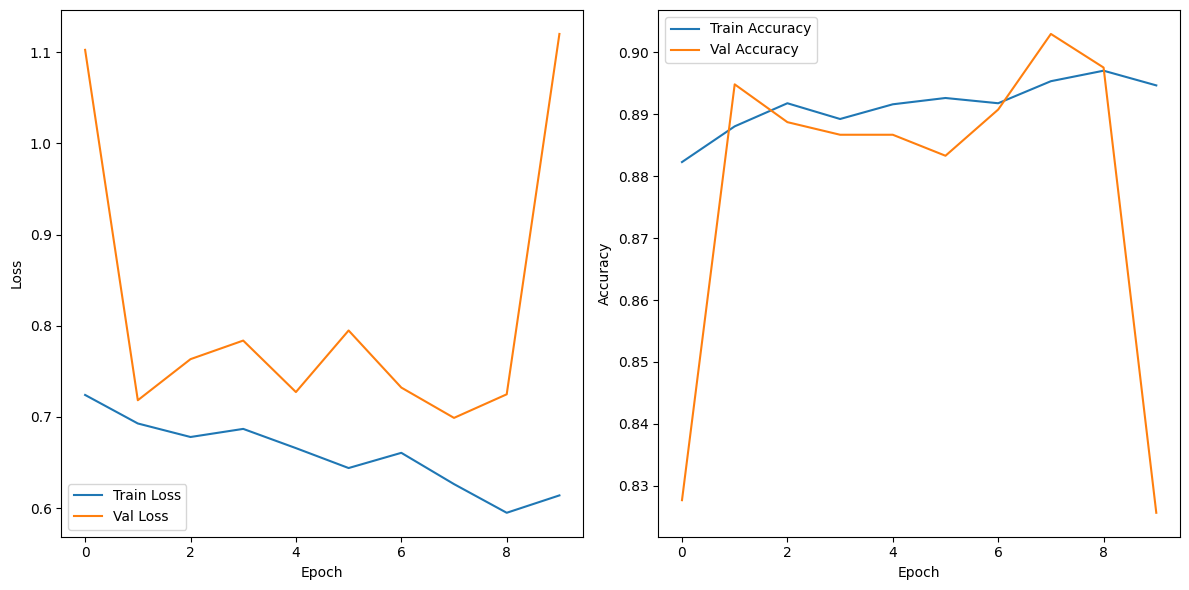

In [ ]:
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Inference

<ipython-input-24-4950273f42a9>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


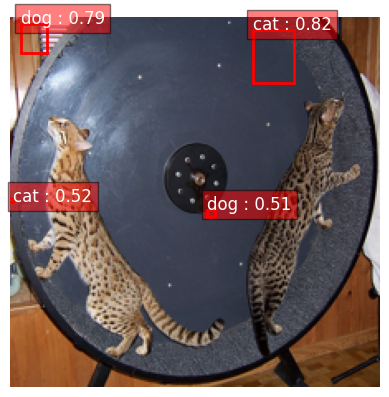

In [ ]:
def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
    model.eval()

    # Load and prepare the image
    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    # Resize the image to match the imput size expected by the model
    resized_image = image.resize((224, 224))
    resized_width, resized_height = resized_image.size

    # Apply the same transformations used during training
    transformed_image = transform(resized_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        # Assuming output is of shape (batch_size, grid_size, grid_size, 4 + len(classes))
        # Adjust this shape based on your model output, here we're assuming a 2x2 grid.
        output = output.view(1, 2, 2, 4 + len(class_to_idx)) # Reshape for 2x2 grid

    fig, ax = plt.subplots(1)
    ax.axis("off")
    ax.imshow(resized_image)

    # Loop through the grid cells
    for grid_y in range(2):
        for grid_x in range(2):
            # Get the class prediction and bounding box for the current grid cell
            class_pred = output[0, grid_y, grid_x, 4:].argmax().item()
            bbox = output[0, grid_y, grid_x, :4].tolist()  # Predicted bounding box

            # Confidence (probability of the predicted class)
            confidence = torch.softmax(output[0, grid_y, grid_x, 4:], dim=0)[class_pred].item()

            # Scale the bounding box coordinates back to the original image size
            # Assuming bbox coordinates are normalized to [0, 1] within the grid cell
            x_min = bbox[0] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_min = bbox[1] * (resized_height / 2) + grid_y * (resized_height / 2)
            x_max = bbox[2] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_max = bbox[3] * (resized_height / 2) + grid_y * (resized_height / 2)

            # Draw the bounding box and label on the image if confidence is above threshold
            if confidence > threshold:
                rect = patches.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=2,
                    edgecolor="r",
                    facecolor="none"
                )
                ax.add_patch(rect)
                plt.text(
                    x_min,
                    y_min,
                    f"{list(class_to_idx.keys())[class_pred]} : {confidence:.2f}",
                    color="white",
                    fontsize=12,
                    bbox=dict(facecolor="red", alpha=0.5)
                )
    plt.show()

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Inference
image_path = os.path.join(image_dir, "Cats_Test736.png")
inference(model, image_path, transform, device, class_to_idx, threshold=0.5)